In [2]:
%reload_ext autoreload
%autoreload 2

import time
from pathlib import Path
from copy import copy, deepcopy
import random
import numpy as np
import scipy as sp
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from dominoes import leagueManager as lm
from dominoes import gameplay as dg
from dominoes import agents as da
from dominoes import utils
from dominoes import files as fm
from dominoes.networks import transformers as transformers
from dominoes import datasets
from dominoes import training
from dominoes.analysis import transformer_analysis as ta
from dominoes import utils

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

ImportError: cannot import name 'transformers' from 'dominoes.networks' (/Users/landauland/Documents/GitHub/dominoes/dominoes/networks/__init__.py)

In [30]:
# TODO For refactoring
# continue working on generate_batch method in DominoesDataset
# generate_batch method needs help with "set_target"

In [25]:
%reload_ext autoreload
%autoreload 2

import torch
from dominoes.datasets.support import get_dominoe_set
from dominoes.datasets.base import DominoeDataset

In [38]:

highest_dominoe = 6
dataset = DominoeDataset("sorting", highest_dominoe, hand_size=7)

batch = dataset.generate_batch(train=False, batch_size=2, return_full=True)

print(batch)


# Figure out how to get the gettarget sorting to work!! Then DominoeDataset is finisheddddddddd

    # def _gettarget_sorting(self, dominoes, selection, available, **prms):
    #     # sort and pad each list of dominoes by value
    #     def sortPad(val, padTo, ignoreIndex=-1):
    #         s = sorted(range(len(val)), key=lambda i: -val[i])
    #         p = [ignoreIndex] * (padTo - len(val))
    #         return s + p

    #     # create a padded sort index, then turn into a torch tensor as the target vector
    #     sortIdx = [sort
    # Pad(val, maxSeqLength, ignoreIndex) for val in value]  # pad with ignore index so nll_loss ignores them
    #     target = torch.stack([torch.LongTensor(idx) for idx in sortIdx])

{'input': tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]), 'mask': tensor([[1., 1., 1., 1., 1., 1., 1.],
 

In [9]:
%%time 

highestDominoe = 9
numPlayers = 4
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers) 
game.playGame(rounds=500) # Play the game 

CPU times: user 3.49 s, sys: 39.7 ms, total: 3.53 s
Wall time: 3.62 s


In [10]:
game.printResults(fullScore=True)

Scores for each round:
[[ 0 22  8 15]
 [21  6  0 19]
 [22  0 26 21]
 ...
 [ 8 19  7  0]
 [19 16  9 13]
 [ 0 21 51 10]]

Average score per hand:
[15.63 15.37 15.76 15.43]

Number times going out:
[ 94 115  91  95]

The winner is agent: 1 with an average hand score of 15.37.


In [5]:
utils.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None, labelLines=True)
utils.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None, labelLines=True) 

player 0:  [' 7|1 ', ' 1|6 ', ' 6|4 ', ' 4|1 ', ' 1|8 ', ' 8|8 ']
player 1:  [' 7|9 ', ' 9|4 ', ' 4|0 ', ' 0|9 ', ' 9|6 ', ' 6|6 ']
player 2:  [' 7|3 ', ' 3|1 ', ' 1|0 ', ' 0|0 ', ' 0|6 ']
player 3:  [' 7|5 ', ' 5|8 ', ' 8|3 ', ' 3|9 ', ' 9|5 ', ' 5|0 ', ' 0|3 ', ' 3|3 ']
dummy:  [' 7|0 ', ' 0|8 ', ' 8|6 ', ' 6|7 ', ' 7|2 ', ' 2|4 ', ' 4|7 ', ' 7|8 ', ' 8|2 ', ' 2|5 ', ' 5|1 ', ' 1|2 ', ' 2|2 ', ' 2|6 ', ' 6|3 ', ' 3|4 ', ' 4|8 ', ' 8|9 ', ' 9|9 ', ' 9|1 ', ' 1|1 ']


In [18]:
"""
Dominoes tasks:
1. Plot valueAgentELO results effectively, document it
2. Train a library of lineValueAgents on a server
3. Build a policy-only agent
   - learn network approximation of value function same way other agents do
   - process hand and game state to generate a context embedding
   - then use pointer networks to choose which option to play based on the option encoding and the context
   - policy updated with temporal-difference of the value function
4. Build a win-probability agent method (to be applied to all agents) 
   - I think this is going to involve a bit of cleaning and refactoring of my agents code

Dominoes Experiments:
1. Compare lineValueNetwork trained on only it's turn vs. all turns. vs. it's turn and next turn
2. Compare value agents trained with hand-continuity of eligibility traces or resets

Dominoes Analysis Goals:
1. Study some of the key layers of agent value networks!
2. Initialize the game many times and correalte lineValueFeatures with final score output

Dominoes Coding Practice:
1. Still need to refactor some of the "experiment" scripts to make sure they divide results and plotting 
"""


"""
Pointer Immediate Tasks:
1. Use a separate value network to force encoding to predict the total rewards of the pointer output
2. Run an experiment where I take trained pointer networks and transition them to a dominoe based value 
function and a gamma < 1, and show that they can learn to prioritize playing high value dominoes first. Then...
3. Add the context vector that encodes the number of turns left (with uncertainty?)
    - so the full pointer network will get an extra context input that describes how many turns are left
    - 0 rewards will be given after the possible turns are over
    - so the network will have to learn to get as much value out as quickly as possible
4. Also apply these networks to the vehicle routing problem?
5. Analyze encoding space of pointer networks...
6. Do the encoder swap of different pointer layers...
7. Does the speed of learning for the different networks on the sequencer task come from true performance or just sensitivity to the temperature? 

Pointer Big Ideas:
1. Develop new tasks based on graphs, random forests, and complex rules and determine whether the sophisticated 
pointer layer architecture works better on them. 

Pointer Coding Practice:
1. Convert reward functions to a class 
2. Convert dataset preparation to a class

Pointer Mechanical Update:
1. Change it to learn an initial decoder to be used whenever an input position isn't provided! 
   - self.custom_tensor = nn.Parameter(torch.randn(input_size, output_size), requires_grad=True)
2. Add mechanism for storing hidden parameters to entire pointer network
"""

# THE CODE IS PRETTY UNORGANIZED :(
   # update all experiment files to have smarter mechanism of handling arguments, with default arguments registered in utils
   # update pointer network to have a separate "encoder" module and a "decoder" module (then I can reuse and redeploy the encoder module in different kinds of networks)
   # begin the process of dividing the transformer related code into unique modules
   # need to have a dev branch and keep the main nice and tidy
   # need to organize the dominoes agents better (especially with regards to whether they predict their final score or the win probability)

"\nPointer Immediate Tasks:\n1. Use a separate value network to force encoding to predict the total rewards of the pointer output\n2. Run an experiment where I take trained pointer networks and transition them to a dominoe based value \nfunction and a gamma < 1, and show that they can learn to prioritize playing high value dominoes first. Then...\n3. Add the context vector that encodes the number of turns left (with uncertainty?)\n    - so the full pointer network will get an extra context input that describes how many turns are left\n    - 0 rewards will be given after the possible turns are over\n    - so the network will have to learn to get as much value out as quickly as possible\n4. Also apply these networks to the vehicle routing problem?\n5. Analyze encoding space of pointer networks...\n6. Do the encoder swap of different pointer layers...\n7. Does the speed of learning for the different networks on the sequencer task come from true performance or just sensitivity to the tempe

In [7]:
from scipy.ndimage import median_filter
from scipy.stats import ttest_rel

# general variables for experiment
POINTER_METHODS = ['PointerStandard', 'PointerDot', 'PointerDotLean', 'PointerDotNoLN', 'PointerAttention', 'PointerTransformer']
numNets = len(POINTER_METHODS)

# method for returning the name of the saved network parameters (different save for each possible opponent)
def getFileName(baseName, extra=None):
    if extra is not None:
        baseName = baseName + f"_{extra}"
    return baseName

pretrained_method = 'PointerStandard'

# Load previously stored settings and pretrained networks 
baseName = 'ptrArchComp_sequencer_RL_withBaseline'
results, args = utils.loadSavedExperiment(fm.prmPath(), fm.resPath(), getFileName(baseName))
nets = [torch.load(fm.netPath() / getFileName(baseName, extra=f"{pretrained_method}.pt")) for _ in POINTER_METHODS]
for net, method in zip(nets, POINTER_METHODS):
    net.pointer_method = method
    net.pointer.pointer_method = method
    # build pointer (chooses an output)
    if method == 'PointerStandard':
        # output of the network uses a pointer attention layer as described in the original paper
        net.pointer.pointer = transformers.PointerStandard(net.pointer.embedding_dim)

    elif method == 'PointerDot':
        net.pointer.pointer = transformers.PointerDot(net.pointer.embedding_dim)

    elif method == 'PointerDotNoLN':
        net.pointer.pointer = transformers.PointerDotNoLN(net.pointer.embedding_dim)

    elif method == 'PointerDotLean':
        net.pointer.pointer = transformers.PointerDotLean(net.pointer.embedding_dim)
        
    elif method == 'PointerAttention':
        kwargs = {'heads':net.heads, 'kqnorm':net.kqnorm}
        net.pointer.pointer = transformers.PointerAttention(net.pointer.embedding_dim, **kwargs)

    elif method == 'PointerTransformer':
        kwargs = {'heads':net.heads, 'expansion':1, 'kqnorm':net.kqnorm, 'bias':net.bias}
        net.pointer.pointer = transformers.PointerTransformer(net.pointer.embedding_dim, **kwargs)
        
    else:
        raise ValueError(f"the pointer_method was not set correctly, {args.pointer_layer} not recognized")
nets = [net.to(device) for net in nets]

# Define parameters to be learned and turn off gradients in all other parameters
learning_parameters = [[] for _ in nets]
for learn, net in zip(learning_parameters, nets):
    for name, prm in net.named_parameters():
        if 'pointer.pointer' in name:
            prm.requires_grad = True
            learn.append(prm)
        else:
            prm.requires_grad = False

# Prepare optimizer for the specific parameters to be learned
optimizers = [torch.optim.Adam(learn, lr=1e-3, weight_decay=1e-5) for learn in learning_parameters]


def resetBaselines(blnets, batchSize, highestDominoe, listDominoes, handSize, num_output, value_method, **kwargs):
    # initialize baseline input (to prevent overfitting with training data)
    batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, **kwargs)
    baselineinput, _, _, _, _, baseline_selection, baseline_available = batch 
    baselineinput = baselineinput.to(device) # move to device

    # divide input into main input and context
    baseline_x, baseline_context = baselineinput[:, :-1].contiguous(), baselineinput[:, [-1]] # input [:, [-1]] is context token
    baseline_input = (baseline_x, baseline_context)

    _, baseline_choices = map(list, zip(*[net(baseline_input, max_output=num_output) for net in blnets]))

    # measure rewards for each sequence
    baseline_rewards = [training.measureReward_sequencer(baseline_available, listDominoes[baseline_selection], choice, value_method=value_method, normalize=False)
                for choice in baseline_choices]

    return baseline_input, baseline_selection, baseline_available, baseline_rewards 


def get_gamma_transform(gamma, N):
    exponent = torch.arange(N).view(-1,1) - torch.arange(N).view(1,-1)
    gamma_transform = (gamma ** exponent * (exponent >= 0))
    return gamma_transform


# get values from the argument parser
highestDominoe = args.highest_dominoe
listDominoes = utils.listDominoes(highestDominoe)

handSize = args.hand_size
batchSize = args.batch_size
null_token = True # using a null token to indicate end of line
null_index = copy(handSize) # index of null token
available_token = True # using available token to indicate which value to start on 
ignore_index = -1
value_method = '1' # method for generating rewards in reward function

num_output = copy(handSize)
gamma = args.gamma
gamma_transform = get_gamma_transform(gamma, num_output).to(device)

# other batch parameters
batchSize = args.batch_size
baselineBatchSize = args.baseline_batch_size
significance = args.significance
do_baseline = not(args.nobaseline)

# network parameters
temperature = args.temperature

# train parameters
trainEpochs = 8000 #args.train_epochs
testEpochs = 100 #args.test_epochs

print(f"Doing training...")
trainReward = torch.zeros((trainEpochs, numNets))
testReward = torch.zeros((testEpochs, numNets))
testEachReward = torch.zeros((testEpochs, numNets, batchSize))
testMaxReward = torch.zeros((testEpochs, batchSize))


if do_baseline:
    # create baseline nets, initialized as copy of learning nets
    blnets = [deepcopy(net) for net in nets]
    for blnet in blnets:
        blnet.setTemperature(1.0)
        blnet.setThompson(True)

    baseline_kwargs = dict(return_target=False, null_token=null_token, available_token=available_token, 
                            ignore_index=ignore_index, return_full=True)            
    baseline_data = resetBaselines(blnets, baselineBatchSize, highestDominoe, listDominoes, handSize, num_output, value_method, **baseline_kwargs)
    baseline_input, baseline_selection, baseline_available, baseline_rewards = baseline_data
    

for epoch in tqdm(range(trainEpochs)):
    # generate input batch
    batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, return_target=False, null_token=null_token,
                                available_token=available_token, ignore_index=ignore_index, return_full=True)

    # unpack batch tuple
    input, _, _, _, _, selection, available = batch

    # move to correct device
    input = input.to(device)

    # divide input into main input and context
    x, context = input[:, :-1].contiguous(), input[:, [-1]] # input [:, [-1]] is context token
    input = (x, context)
    
    # zero gradients, get output of network
    for opt in optimizers: opt.zero_grad()
    log_scores, choices = map(list, zip(*[net(input, max_output=num_output) for net in nets]))

    # measure rewards for each sequence
    rewards = [training.measureReward_sequencer(available, listDominoes[selection], choice, value_method=value_method, normalize=False)
                for choice in choices]
    G = [torch.matmul(reward, gamma_transform) for reward in rewards]
    logprob_policy = [torch.gather(score, 2, choice.unsqueeze(2)).squeeze(2)
                        for score, choice in zip(log_scores, choices)] # log-probability for each chosen dominoe
    
    if do_baseline:
        # - do "baseline rollout" with baseline networks - 
        with torch.no_grad():
            _, bl_choices = map(list, zip(*[net(input, max_output=num_output) for net in blnets]))
            bl_rewards = [training.measureReward_sequencer(available, listDominoes[selection], choice, value_method=value_method, normalize=False)
                            for choice in bl_choices]
            bl_G = [torch.matmul(reward, gamma_transform) for reward in bl_rewards]
            adjusted_G = [g-blg for g, blg in zip(G, bl_G)] # baseline corrected G
    else:
        # for a consistent namespace
        adjusted_G = [g for g in G]

    # do backward pass on J and update networks
    for policy, g, opt in zip(logprob_policy, adjusted_G, optimizers):
        J = -torch.sum(policy * g)
        J.backward()
        opt.step()

    # save training data
    for i, reward in enumerate(rewards):
        trainReward[epoch, i] = torch.mean(torch.sum(reward, dim=1))

    
    # check if we should update baseline networks
    if do_baseline:
        with torch.no_grad():
            # first measure policy on baseline data (in evaluation mode)
            for net in nets: 
                net.setTemperature(1.0)
                net.setThompson(False)

            _, choices = map(list, zip(*[net(baseline_input, max_output=num_output) for net in nets]))
            rewards = [training.measureReward_sequencer(baseline_available, listDominoes[baseline_selection], choice, value_method=value_method, normalize=False)
                        for choice in choices]
            
            _, p = map(list, zip(*[ttest_rel(r.view(-1).cpu().numpy(), blr.view(-1).cpu().numpy(), alternative='greater')
                                    for r, blr in zip(rewards, baseline_rewards)]))
            do_update = [pv<significance for pv in p]

            # for any networks with significantly different values, update them
            for ii, update in enumerate(do_update):
                if update:
                    blnets[ii] = deepcopy(nets[ii])
                    blnets[ii].setTemperature(1.0)
                    blnets[ii].setThompson(False)

            # regenerate baseline data and get baseline network policy
            if any(do_update):
                baseline_data = resetBaselines(blnets, baselineBatchSize, highestDominoe, listDominoes, handSize, num_output, value_method, **baseline_kwargs)
                baseline_input, baseline_selection, baseline_available, baseline_rewards = baseline_data
                
            # return nets to training state
            for net in nets: 
                net.setTemperature(temperature) 
                net.setThompson(True)

with torch.no_grad():
    print('Testing network...')
    for net in nets:
        net.setTemperature(1.0)
        net.setThompson(False)

    for epoch in tqdm(range(testEpochs)):
        # generate input batch
        batch = datasets.generateBatch(highestDominoe, listDominoes, batchSize, handSize, return_target=True, null_token=null_token,
                                    available_token=available_token, ignore_index=ignore_index, return_full=True, value_method='length')

        # unpack batch tuple
        input, target, _, _, _, selection, available = batch
        assert torch.all(torch.sum(target==null_index, dim=1)==1), "null index is present more or less than once in at least one target"

        # move to correct device
        input, target = input.to(device), target.to(device)
        target = target[:, :num_output].contiguous()
        target[target==ignore_index]=null_index # need to convert this to a valid index for measuring reward of target

        # divide input into main input and context
        x, context = input[:, :-1].contiguous(), input[:, [-1]] # input [:, [-1]] is context token
        input = (x, context)
        
        log_scores, choices = map(list, zip(*[net(input, max_output=num_output) for net in nets]))

        # measure rewards for each sequence
        rewards = [training.measureReward_sequencer(available, listDominoes[selection], choice, value_method=value_method, normalize=False)
                for choice in choices]
        
        # save testing data
        for i, reward in enumerate(rewards):
            testReward[epoch, i] = torch.mean(torch.sum(reward, dim=1))
            testEachReward[epoch, i] = torch.sum(reward, dim=1)

        # measure rewards for target (defined as longest possible sequence of the dominoes in the batch
        target_reward = training.measureReward_sequencer(available, listDominoes[selection], target, value_method=value_method, normalize=False)
        testMaxReward[epoch] = torch.sum(target_reward, dim=1)
            
        
results = {
    'trainReward': trainReward,
    'testReward': testReward,
    'testEachReward': testEachReward,
    'testMaxReward': testMaxReward,
}

Doing training...


100%|██████████| 8000/8000 [2:09:24<00:00,  1.03it/s]  


Testing network...


100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


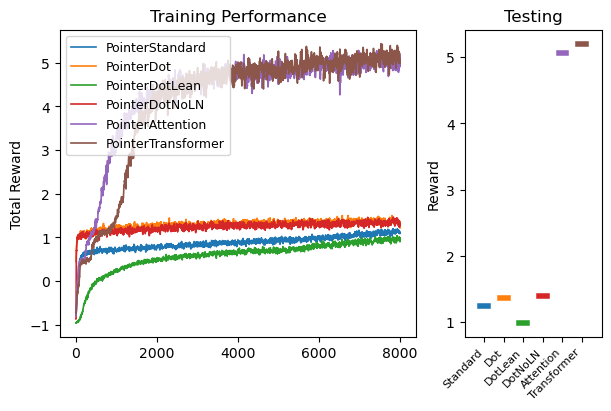

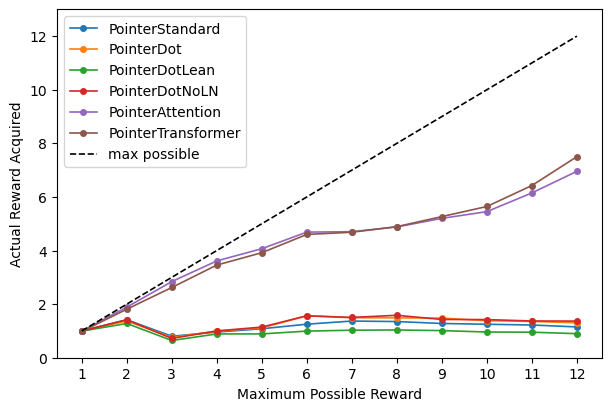

In [8]:
cmap = mpl.colormaps['tab10']

# Process test results in comparison to maximum possible
minMaxReward = torch.min(results['testMaxReward'])
maxMaxReward = torch.max(results['testMaxReward'])
uniqueRewards = torch.arange(minMaxReward, maxMaxReward+1)
numUnique = len(uniqueRewards)
rewPerMax = torch.zeros((len(POINTER_METHODS), numUnique))
for iur, ur in enumerate(uniqueRewards):
    idx_ur = results['testMaxReward']==ur
    for ii, name in enumerate(POINTER_METHODS):
        rewPerMax[ii, iur] = torch.mean(results['testEachReward'][:, ii][idx_ur])
            
# make plot of performance trajectory
fig, ax = plt.subplots(1, 2, figsize=(6, 4), width_ratios=[2.6, 1], layout="constrained")
for idx, name in enumerate(POINTER_METHODS):
    adata = median_filter(results['trainReward'][:,idx], size=(10,))
    ax[0].plot(range(trainEpochs), adata, color=cmap(idx), lw=1.2, label=name)
ax[0].set_ylabel(f'Total Reward')
ax[0].set_title('Training Performance')
ax[0].legend(loc='best', fontsize=9)
# ax[0].set_xticks([0, 2500, 5000, 7500, 10000])
ylims = ax[0].get_ylim()

xOffset = [-0.2, 0.2]
get_x = lambda idx: [xOffset[0]+idx, xOffset[1]+idx]
for idx, name in enumerate(POINTER_METHODS):
    mnTestReward = torch.mean(results['testReward'][:,idx], dim=0)
    ax[1].plot(get_x(idx), [mnTestReward, mnTestReward], color=cmap(idx), lw=4, label=name)
ax[1].set_xticks(range(len(POINTER_METHODS)))
ax[1].set_xticklabels([pmethod[7:] for pmethod in POINTER_METHODS], rotation=45, ha='right', fontsize=8)
ax[1].set_ylabel(f'Reward')
ax[1].set_title('Testing')
ax[1].set_xlim(-1, len(POINTER_METHODS))
# ax[1].set_ylim(ylims)

plt.show()

# Plot rewards in comparison to maximum possible for each network type
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
for idx, name in enumerate(POINTER_METHODS):
    adata = rewPerMax[idx]
    ax.plot(uniqueRewards, adata, color=cmap(idx), lw=1.2, marker='o', markersize=4, label=name)
ax.plot(uniqueRewards, uniqueRewards, color='k', lw=1.2, linestyle='--', label='max possible')
ax.set_ylim(0, max(uniqueRewards)+1)
ax.set_xticks(uniqueRewards)
ax.set_xlabel('Maximum Possible Reward')
ax.set_ylabel('Actual Reward Acquired')
ax.legend(loc='upper left', fontsize=10)

plt.show()


In [ ]:
POINTER_METHODS = ta.POINTER_METHODS
net_lookup = {val:idx for idx,val in enumerate(POINTER_METHODS)}
netidx = lambda x: net_lookup[x]

batchSize = 128
num_cities = 8
baseName = "ptrArchComp_TSP_RL"
results, nets = ta.loadNetworks(baseName)
outs = ta.process_tsp_data(nets, batchSize, num_cities)
embedded, encoded, intermediate, decoder_context, decoder_input, scores, choices, batch = outs
_, xy, dists = batch # don't need the input representation

In [ ]:
# MDS for embedded vs positions
idx = netidx('PointerDot')
dist_method = ta.torch_pdist
dist_data = dist_method(xy.view(batchSize*num_cities, -1))
dist_embedded = dist_method(embedded[idx].view(batchSize*num_cities, -1))
dist_encoded = dist_method(encoded[idx].view(batchSize*num_cities, -1))

In [ ]:
dist_mats = [dist_data, dist_embedded, dist_encoded]
order_data = [ta.compute_serial_matrix(dm.cpu().numpy())[1] for dm in dist_mats]
ser_data = [[ta.seriate_matrix(dm.cpu().numpy(), od) for dm in dist_mats] for od in order_data]


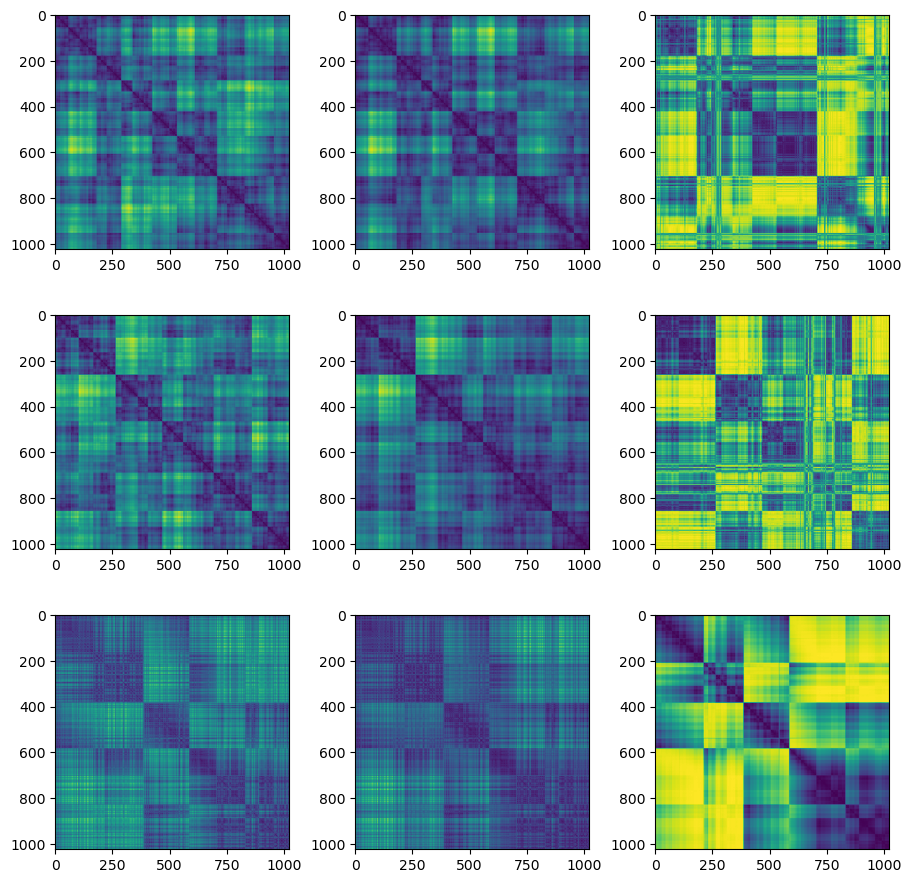

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(9,9), layout='constrained')
for ii in range(3):
    for jj in range(3):
        ax[ii,jj].imshow(ser_data[ii][jj])
plt.show()